### GOPO Poetry

In [1]:
import numpy as np
import pandas as pd
import keras
import eng_to_ipa as ipa

Using TensorFlow backend.


In [2]:
# Set the default values for epochs, number of words to output, and the randomization factor
DEFAULT_EPOCHS = 10
DEFAULT_WORDS = 600
DEFAULT_TEMP = 1.0

### Read poetry into a dataframe and extract the poems

In [3]:
df = pd.read_csv('Multiple_Forms.csv', index_col = 0)
df.head()

,Author,Poem,Form
0,William Shakespeare,"From fairest creatures we desire increase,\r\n...",Sonnet
1,William Shakespeare,"When forty winters shall besiege thy brow,\r\n...",Sonnet
2,William Shakespeare,Look in thy glass and tell the face thou viewe...,Sonnet
3,William Shakespeare,"Unthrifty loveliness, why dost thou spend\r\n ...",Sonnet
4,William Shakespeare,"Those hours, that with gentle work did frame\r...",Sonnet


In [4]:
poems = df['Poem'][df.Form == 'Sonnet']
poems

0     From fairest creatures we desire increase,\r\n...
1     When forty winters shall besiege thy brow,\r\n...
2     Look in thy glass and tell the face thou viewe...
3     Unthrifty loveliness, why dost thou spend\r\n ...
4     Those hours, that with gentle work did frame\r...
                            ...                        
95    Whate'er the cost to me, with this farewell,\n...
96    If the past year were offered me again,\nWith ...
97    Nay, dear one, ask me not to leave thee yet.\n...
98    Where is the pride for which I once was blamed...
99    I sue thee not for pity on my case.\nIf I have...
Name: Poem, Length: 348, dtype: object

### Extract and clean the text

In [5]:
text = ''
for poem in poems:
    text += str(poem) + '\n'
len(text)

258640

In [6]:
text = text.replace("’", "'")
text = text.replace("‘", "'")
text = text.replace("“", " ")
text = text.replace("'d", "ed")
text = text.replace("(", "")
text = text.replace(")", "")
text = text.replace(" '", " ")
text = text.replace("' ", " ")
text = text.replace('"', '')
text = text.replace("--", " ")
text = text.replace(":-", " ")
text = text.replace("-:", " ")
text = text.replace(".-", " ")
text = text.replace("- ", " ")
text = text.replace(" -", " ")
text = text.replace(" –", " ")
while text.find(" . ") != -1:
    text = text.replace(" . ", " ")
while text.find("..") != -1:
    text = text.replace("..", ".")
text = text.replace("?.", "? ")
text = text.replace("!.", "! ")
text = text.replace("!-", "! ")
text = text.replace("!—", "! ")
text = text.replace(".", " ")
text = text.replace(",", " ")
text = text.replace("\n"," eol\n")
text = text.replace("\r"," ")
text = text.replace("bad—the", "bad the")
text = text.replace("occasion—that", "occasion that")

### Convert text string into a list and clean it some more

In [7]:
word_list = text.split()
a = 0
roman_num = ['ii','iii','iv','v','vi','vii','viii','ix','x','xi','xii','xiii','xiv','xv','xvi','xvii',
             'xviii','xix','xx','xxi','xxii','xxiii','xxiv','xxv','xxvi','xxvii','xxviii','xxix','xxx']
for i in range(len(word_list) - a):
    word_list[i - a] = word_list[i - a].lower().strip("“”''-.?:;!,[]~`’—&")
    if word_list[i - a] in ['nan','','*','st'] or word_list[i-a][0] == '&' or word_list[i-a].isdigit() \
     or word_list[i-a] in roman_num:
        word_list.pop(i - a)
        a += 1
len(word_list)

52224

### Create a sorted list of the unique words, vectorize the words and sentences

In [8]:
maxlen = 6                                                            
step = 1 

sentences = []                                                         

next_words = []                                                        

for i in range(0, len(word_list) - maxlen, step):
    sentences.append(word_list[i: i + maxlen])
    next_words.append(word_list[i + maxlen])

print('Number of sequences:', len(sentences))

words = sorted(list(set(word_list)))                                        
print('Unique words:', len(words))
word_indices = dict((word, words.index(word)) for word in words)       

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(words)), dtype=np.bool)      
y = np.zeros((len(sentences), len(words)), dtype=np.bool)              
for i, sentence in enumerate(sentences):                               
    for t, word in enumerate(sentence):                                
        x[i, t, word_indices[word]] = 1                                
    y[i, word_indices[next_words[i]]] = 1 

Number of sequences: 52218
Unique words: 6645
Vectorization...


### Import phonem library and create a dictionary of words and their phonems

In [9]:
import nltk
from nltk.corpus import cmudict
nltk.download('cmudict')
d = cmudict.dict()

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\kyle_\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [10]:
# Method to add phonems for each word to 'phonem' dict
def syls(word):
    flag = False
    r_word = word[:]
    while len(r_word) > 0 and flag == False:
        try:
            phonem[word] = d[r_word.lower()]
            flag = True        # if no exception occurs then flag is set indicating phonems added to dict
        except Exception as e:
            r_word = r_word[1:]
    if r_word == '':
        phonem[word] = []

In [11]:
# initializes the phonem dict
phonem = {}
# calls the 'syls' method for each word in the 'words' list
for w in words:
    syls(w)
# phonem

### Build the Model

In [12]:
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(512, input_shape=(maxlen, len(words))))
model.add(layers.Dense(len(words), activation='softmax'))

In [13]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [14]:
# method to return a word probability vector
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Methods for finding rhyming words and counting syllables

In [15]:
def rhyming_words(word):
    if word != '':
        for key in phonem:
            len_key = len(phonem[key])
            for i in range(len(phonem[word])):
                for j in range(len_key):
                    if word == key or len_key == 0:
                        continue
                    elif len(phonem[word]) == 1:
                        if phonem[word][i][-1] == phonem[key][j][-1]:
                            rhymers.append(key)
                    elif len(phonem[key]) == 2:
                        if phonem[word][i][-2:] == phonem[key][j][-2:]:
                            rhymers.append(key)
                    else:
                        if phonem[word][i][-3:] == phonem[key][j][-3:]:
                            rhymers.append(key)
#     print(len(rhymers))
    
                                           
def syllable_counter(word):
    count = 0
    if word == '' or word == '\n':
        count = 0
    elif ipa.syllable_count(word) == 0:
        count = len(word) % 3
        if count == 0:
            count = 1
    else:
        count += ipa.syllable_count(word)
    return count

### Text Reading Library

In [16]:
# pip install pyttsx3==2.71

In [17]:
# importing the pyttsx library
import pyttsx3

In [18]:
# initialize the engine and set the reading rate
engine = pyttsx3.init()
# rate = engine.getProperty('rate')
engine.setProperty('rate', 150)

### Set values for the number of epochs, words to output, and the randomizing factor (temperature)

In [19]:
# Set the number of training epochs
num = input("Enter Number of Epochs from 1 to 20: ")
if num.isdigit() and int(num) <= 20 and int(num) > 0:
    num_epochs = int(num)
    print("Setting Epochs = ", num_epochs)
    
else:
    num_epochs = DEFAULT_EPOCHS
    print("Incorrect Input, Setting Epochs = ", num_epochs)

Enter Number of Epochs from 1 to 20: 20
Setting Epochs =  20


In [20]:
# Set the number of words to output
num = input("Enter Number of Words to output from 100 to 1600: ")
if num.isdigit() and int(num) <= 1600 and int(num) >= 100:
    num_words = int(num)
    print("Setting # of words = ", num_words)
    
else:
    num_words = DEFAULT_WORDS
    print("Incorrect Input, Setting Words = ", num_words)

Enter Number of Words to output from 100 to 1600: 160
Setting # of words =  160


In [21]:
# Set the randomization factor (temperature)
flt = input("Enter randomizer factor from 0.2 to 1.5: ")
try:
        temperature = float(flt)
        if temperature >= 0.2 and temperature <= 1.5:
            print("Setting Randomizer Factor = ", temperature)
        else:
            temperature = DEFAULT_TEMP
            print("Incorrect Input, Setting Randomizer Factor = ", temperature)
except ValueError:
        temperature = DEFAULT_TEMP
        print("Incorrect Input, Setting Randomizer Factor = ", temperature)

Enter randomizer factor from 0.2 to 1.5: 1.0
Setting Randomizer Factor =  1.0


### Train the Model

In [22]:
hist = model.fit(x, y, batch_size=512, epochs=num_epochs)

Epoch 1/20
52218/52218 [==============================] - 181s 3ms/step - loss: 6.8807
Epoch 2/20
52218/52218 [==============================] - 179s 3ms/step - loss: 6.4503
Epoch 3/20
52218/52218 [==============================] - 1184s 23ms/step - loss: 6.2337
Epoch 4/20
52218/52218 [==============================] - 177s 3ms/step - loss: 5.9094
Epoch 5/20
52218/52218 [==============================] - 176s 3ms/step - loss: 5.6039
Epoch 6/20
52218/52218 [==============================] - 177s 3ms/step - loss: 5.2031
Epoch 7/20
52218/52218 [==============================] - 178s 3ms/step - loss: 4.5726
Epoch 8/20
52218/52218 [==============================] - 177s 3ms/step - loss: 3.6514
Epoch 9/20
52218/52218 [==============================] - 179s 3ms/step - loss: 2.6006
Epoch 10/20
52218/52218 [==============================] - 1221s 23ms/step - loss: 1.6241
Epoch 11/20
52218/52218 [==============================] - 179s 3ms/step - loss: 0.8959
Epoch 12/20
52218/52218 [============

In [23]:
input("Press 'Enter' to continue: ")

Press 'Enter' to continue: 


''

### Write the Poetry

In [24]:
import random
import sys
import time

# create file with unique timestamp
t = time.localtime()
timestamp = time.strftime('%b-%d-%Y_%H%M', t)
FILE_NAME = ("poem_output_" + timestamp + ".txt")
file = open(FILE_NAME, 'a')

# initialize variables and assign values 
RHYME_CHECK = 5

model_loss = {}
model_loss['loss'] = []

line_count = 0
quatrain_count = 0
quatrain = False
new_line = False
app_word = ''
end_of_line = False

count = 0    # counts number of syllables on a line

generated_text = ''
generated_list = []

# select list of words starting a randomly selected index
start_index = random.randint(0, len(word_list) - maxlen - 1)         
generated_list = word_list[start_index: start_index + maxlen]

# create a string from the list
for word in generated_list:
    generated_text += word + ' '
generated_text =  generated_text.strip()

print('--- Generating with seed: "' + generated_text + '"')
file.write('--- Generating with seed: "' + generated_text + '"\n')

for num in ipa.syllable_count(generated_text):
    count += num
    
generated_text = generated_text.replace('eol ','')
generated_text = generated_text.replace('eol','')
generated_text = generated_text.replace(' i ',' I ')
generated_text = generated_text.capitalize()

print('------ temperature:', temperature)
file.write('------ temperature: ' + str(temperature) + '\n')
sys.stdout.write(' ' + generated_text)
file.write(' ' + generated_text)

# write out the words of the poems
for i in range(num_words):                                        
    sampled = np.zeros((1, maxlen, len(words)))             
    for t, word in enumerate(generated_list):               
        sampled[0, t, word_indices[word]] = 1. 

    if count >= 10:
        end_of_line = True
        count = 0 

    # finds rhyming word for the end of the third line
    if line_count == 2 and count >= RHYME_CHECK:
        preds = model.predict(sampled, verbose=0)[0] * z1
        next_index = sample(preds, temperature)                 
        next_word = words[next_index]
        if count + syllable_counter(next_word) >= 10:
#                     sys.stdout.write(' THIRD LINE')
#                     print(' WORD:', next_word, end='')
            line_count += 1 
            if quatrain_count == 3:
                line_count += 1
                quatrain_count = 0
        else:
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)                 
            next_word = words[next_index]
            while (count + syllable_counter(next_word)) >= 10:
                next_index = sample(preds, temperature)                 
                next_word = words[next_index] 

    # finds rhyming word for the end of the fourth line
    elif line_count == 3 and count >= RHYME_CHECK:
        preds = model.predict(sampled, verbose=0)[0] * z2
        next_index = sample(preds, temperature)                 
        next_word = words[next_index]
        if (count + syllable_counter(next_word) >= 10):
#                     sys.stdout.write('     FOURTH LINE')
            line_count += 1
            quatrain_count += 1
        else:
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)                 
            next_word = words[next_index]
            while (count + syllable_counter(next_word)) >= 10:
                next_index = sample(preds, temperature)                 
                next_word = words[next_index] 

    else:
        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)                 
        next_word = words[next_index]

    if count < 10 and next_word == 'eol':
        next_word = ''
        app_word = generated_list[maxlen - 1]
    elif end_of_line:
        app_word = next_word = 'eol'
        end_of_line = False
        count = 0
    else:
        app_word = next_word

    generated_list.append(app_word)
    generated_list = generated_list[1:]

    if new_line and next_word == 'eol':
        next_word = ''
    elif new_line:
        next_word = next_word.capitalize()
        new_line = False
    elif next_word == 'i':
        next_word = next_word.upper()
    elif next_word == 'eol':
        next_word = '\n'
        new_line = True
    if next_word != '':    
        sys.stdout.write(' ' + next_word)
        file.write(' ' + next_word)
        syl_num = syllable_counter(next_word)
        count += syl_num

    if count >= 10:
        if line_count == 0:
#                     sys.stdout.write('     FIRST LINE')
            rhymers = []
            z1 = np.zeros(len(words)) + 0.0001
#                     print("\nNext Word:", next_word)
            r_word = next_word[:].lower()
            r_word = r_word.strip(",.?!:;-'\"_")   
#                     print(r_word)
            rhyming_words(r_word)
#                     print(rhymers)
            for rhyme in rhymers:
                if rhyme in word_indices:
                    z1[word_indices[rhyme]] = 10000.
            line_count += 1
            if quatrain_count == 3:
                line_count += 1

        elif line_count == 1:
#                     sys.stdout.write('  SECOND LINE')
            rhymers = []
            z2 = np.zeros(len(words)) + 0.0001
#                     print("\nNext Word:", next_word)
            r_word = next_word[:].lower()
            r_word = r_word.strip(",.?!:;-'\"_")   
#                     print(r_word)
            rhyming_words(r_word)
#                     print(rhymers)
            for rhyme in rhymers:
                if rhyme in word_indices:
                    z2[word_indices[rhyme]] = 10000.
            line_count += 1
#                     print('     LINE COUNT:', line_count, end = '')

        elif line_count == 4:
            print()
            file.write('\n')
            line_count = 0
file.close()

--- Generating with seed: "eol since first i saw you"
------ temperature: 1.0
 Since first i saw you fresh which yet are green 
 Belovëd in the unaccomplished gives to I shame truly 
 Nor gardens canst thou maiden therein 
 Make me our blossom by most near only
 
 Ever her husband so further from waited 
 To all judgment make that best do room outward 
 Fates and purest faith and dedicated 
 The gilded honour dumb that fell and third
 
 That make me feele forth but so conquer 
 Living panting roses thing can be nothing 
 So so I heart not ease for thine be silver 
 Though not be loss back and all listening
 
 And sweetest twilight half such a face as 
 The beauty should captiues thine truth for whenas
 
 Fury I aspire because passed in map 
 Bridges there here hand against my see

### Read the Poetry

In [25]:
f = open(FILE_NAME, 'r')
f.readline()
f.readline()
txt = f.read()

In [26]:
engine.say(txt)
engine.runAndWait()
engine.stop()

### Plot the loss for each epoch

In [27]:
model_loss = hist.history

In [28]:
import matplotlib.pyplot as plt 

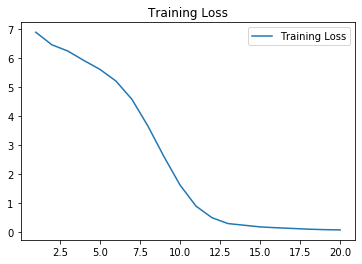

In [29]:
plt.plot([x + 1 for x in range(len(model_loss['loss']))], model_loss['loss'], label = 'Training Loss')
plt.legend()
plt.title('Training Loss')
plt.show()